In [1]:
!pip install unrar
!unrar x "/content/pro.rar"



UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/pro.rar

Creating    weights                                                   OK
Extracting  weights/best.pt                                               15% 31% 46% 62% 77%  OK 
Extracting  weights/yolov8n_char_new.pt                                   92% 98%  OK 
Extracting  requirements.txt                                              98%  OK 
Creating    assets                                                    OK
Extracting  assets/English.jpg                                            99%  OK 
Extracting  assets/Iranian.jpg                                            99%  OK 
Creating    output                                                    OK
All OK


In [8]:
!pip install -r requirements.txt

In [9]:
import easyocr
reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [10]:
import matplotlib.pyplot as plt
from ultralytics import YOLO
import easyocr
import cv2
import math
import time
import datetime

In [23]:
# Get the current timestamp for output names
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
# Define the file name with the timestamp
file_name = f'output_{timestamp}.jpg'
classnames = ['car', 'plate']
charclassnames = ['0','9','b','d','ein','ein','g','gh','h','n','s','1','malul','n','s','sad','t','ta','v','y','2'
                  ,'3','4','5','6','7','8']
source = "assets/Iranian.jpg"
#load YOLOv8 model
model_object = YOLO("weights/best.pt")
model_char = YOLO("weights/yolov8n_char_new.pt")

In [24]:
cap = cv2.VideoCapture(source)
# Define the output video properties
output_videoname = f'output_{timestamp}.mp4'
output_imagename = f'output_{timestamp}.jpg'
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))


In [25]:
output = model_object(source, show=False, conf=0.75)
img = cv2.imread(source)
#extract bounding box and class names
for i in output:
    bbox = i.boxes
    for box in bbox:
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        cv2.rectangle(img,(x1, y1), (x2, y2), (255, 0, 0), 1)
        confs = math.ceil((box.conf[0]*100))/100
        cls_names = int(box.cls[0])
        if cls_names == 1:
            cv2.putText(img, f'{confs}', (max(40, x2 + 5), max(40, y2 + 5)), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.5, color=(0, 20, 255),thickness=1, lineType=cv2.LINE_AA)
        elif cls_names == 0:
            cv2.putText(img, f'{confs}', (max(40, x1), max(40, y1)), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.6, color=(0, 20, 255),thickness=1, lineType=cv2.LINE_AA)

        #check plate to recognize characters with yolov8n model
        if cls_names == 1:
            char_display = []
            #crop plate from frame
            plate_img = img[y1:y2, x1:x2]
            # cv2.imwrite('plate_img.png', plate_img)



image 1/1 /content/assets/Iranian.jpg: 512x640 1 Car, 1 Plate, 579.6ms
Speed: 2.9ms preprocess, 579.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


## for Iranian plate

In [26]:
#detect characters of plate with yolov8n model
plate_output = model_char(plate_img, conf=0.4)

#extract bounding box and class names
bbox = plate_output[0].boxes.xyxy
cls = plate_output[0].boxes.cls

#make a dict and sort it from left to right to show the correct characters of plate
keys = cls.numpy().astype(int)
values =bbox[:, 0].numpy().astype(int)
dictionary = list(zip(keys, values))
sorted_list = sorted(dictionary, key=lambda x: x[1])

#convert all characters to a string
for i in sorted_list:
    char_class = i[0]
    #char_display.append(plate_output[0].names[char_class])
    char_display.append(charclassnames[char_class])

char_result = (''.join(char_display))


0: 160x416 1 2, 1 23, 1 3, 2 5s, 2 6s, 1 9, 43.8ms
Speed: 0.8ms preprocess, 43.8ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 416)


## for English plate

In [20]:
char_result = str(reader.readtext(plate_img, detail = 0)[0])

In [27]:
#just show the correct characters in output
print("plate:", char_result)
if True:
    cv2.line(img, (max(40, x1 - 25 ), max(40, y1 - 10)), (x2 + 25 ,y1 - 10), (0, 0, 0), 20,lineType=cv2.LINE_AA)
    cv2.putText(img, char_result , (max(40, x1 - 15), max(40, y1 - 5)), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.5, color=(10, 50, 255),thickness=1, lineType=cv2.LINE_AA)


plate: 81sad42455


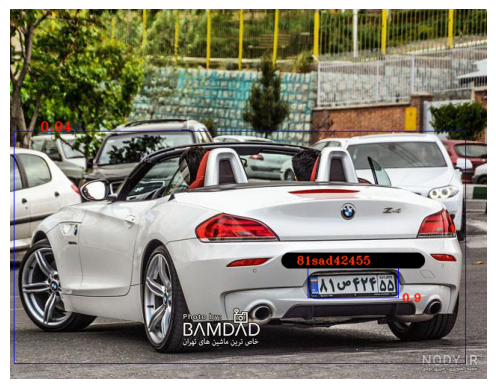

<Figure size 640x480 with 0 Axes>

In [28]:
# we also need to tell this to matplotlib while displaying the image
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Using plt.imshow() to display the image
plt.imshow(RGB_img)
plt.axis('off')
plt.show()

# Save the image using plt.savefig()
output_imagename = 'output.jpg'
plt.savefig('output/' + output_imagename)
